In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet


2024-05-28 16:37:57.022710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 16:37:57.541450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-28 16:37:57.541509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-28 16:37:57.541515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Augment fns

In [2]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# Load Data

In [3]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)


# Resnet K-Fold

In [17]:
def k_fold_finetune_resnet(k, X_train, Y_train, freeze_layers=8, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    kf = KFold(n_splits=k)
    X_input = keras.Input(shape=X_train.shape[1:])
    
    layers_to_freeze_substrings = [f"_{i}_" for i in range(1, freeze_layers)]
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_train == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
        
        print(f"Training on fold {i+1}")
        
        # make model
        out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
        fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        if weights_path:
            fine_tuned_model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in fine_tuned_model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
        history = fine_tuned_model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=X_train.shape[0]//batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = fine_tuned_model.evaluate(X_val_fold, Y_val_fold, batch_size=32)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        
        
        print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val F1 Score: {val_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            fine_tuned_model.save_weights('model-weights/resnet10_simclr_model_finetuned_brugada.h5')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')   
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")
    
    # load best model
    fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
    fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    fine_tuned_model.load_weights('model-weights/resnet10_simclr_model_finetuned_brugada.h5')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1 Score: {test_f1}")
    

# No Pre-training

Training on fold 1
35/35 [==============================] - 0s 4ms/step - loss: 0.2233 - accuracy: 0.9336 - precision: 0.8621 - recall: 0.7919  
Val Accuracy: 0.9335727095603943, Val Precision: 0.8620689511299133, Val Recall: 0.7918552160263062, Val F1 Score: 0.825471698258426
Training on fold 2
33/33 [==============================] - 0s 4ms/step - loss: 0.2594 - accuracy: 0.9335 - precision: 0.9142 - recall: 0.8099      
Val Accuracy: 0.9335232377052307, Val Precision: 0.9141631126403809, Val Recall: 0.8098859190940857, Val F1 Score: 0.8588709706681875
Training on fold 3
34/34 [==============================] - 0s 5ms/step - loss: 0.4054 - accuracy: 0.9064 - precision: 0.8684 - recall: 0.7831      
Val Accuracy: 0.9064272046089172, Val Precision: 0.8684210777282715, Val Recall: 0.7830508351325989, Val F1 Score: 0.8235294162331457
Training on fold 4
31/31 [==============================] - 0s 4ms/step - loss: 0.4533 - accuracy: 0.9215 - precision: 0.9887 - recall: 0.7821  
Val Accurac

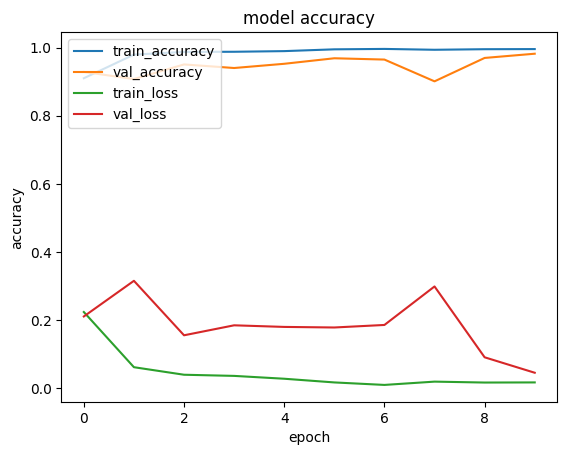

K-Fold Results:
Acuracy: 0.946340948343277 	 +/- 0.02490610963266325
Precision: 0.9011954888701439 	 +/- 0.040992687987244834
Recall: 0.8898598179221153 	 +/- 0.09898823177402029
F1: 0.8918263710896899 	 +/- 0.04984190944633264


68/68 [==============================] - 1s 6ms/step - loss: 0.3028 - accuracy: 0.9449 - precision: 0.8504 - recall: 0.9368   

Test Performance:
Test Accuracy: 0.9448819160461426, Test Precision: 0.8504347801208496, Test Recall: 0.9367815852165222, Test F1 Score: 0.8915223214112487


In [20]:
k_fold_finetune_resnet(8, X_train, Y_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1)

# SimCLR

Training on fold 1
35/35 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9722 - precision: 0.9398 - recall: 0.9186
Val Accuracy: 0.9721723794937134, Val Precision: 0.9398148059844971, Val Recall: 0.918552041053772, Val F1 Score: 0.9290617830655233
Training on fold 2
33/33 [==============================] - 0s 5ms/step - loss: 0.1830 - accuracy: 0.9649 - precision: 0.9593 - recall: 0.8973  
Val Accuracy: 0.9648622870445251, Val Precision: 0.9593495726585388, Val Recall: 0.8973383903503418, Val F1 Score: 0.9273084314260553
Training on fold 3
34/34 [==============================] - 0s 5ms/step - loss: 0.3265 - accuracy: 0.9452 - precision: 0.8835 - recall: 0.9254      
Val Accuracy: 0.9451795816421509, Val Precision: 0.8834951519966125, Val Recall: 0.9254237413406372, Val F1 Score: 0.9039735192423441
Training on fold 4
31/31 [==============================] - 0s 4ms/step - loss: 0.1988 - accuracy: 0.9607 - precision: 0.9598 - recall: 0.9254
Val Accuracy: 0.960

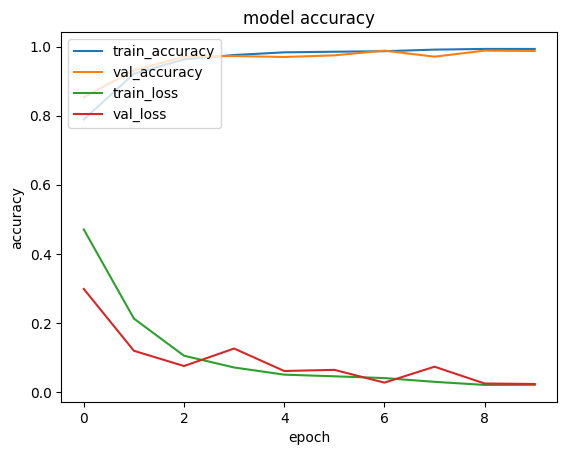

K-Fold Results:
Acuracy: 0.9625810459256172 	 +/- 0.015886924313594158
Precision: 0.9304257556796074 	 +/- 0.03126174809341824
Recall: 0.9204660877585411 	 +/- 0.04611980813717196
F1: 0.9249310518188627 	 +/- 0.033247783804380523


68/68 [==============================] - 1s 5ms/step - loss: 0.1958 - accuracy: 0.9486 - precision: 0.8442 - recall: 0.9655   

Test Performance:
Test Accuracy: 0.9485872983932495, Test Precision: 0.8442211151123047, Test Recall: 0.9655172228813171, Test F1 Score: 0.9008042869497678


In [18]:
k_fold_finetune_resnet(8, X_train, Y_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)

# MoCo v2

Training on fold 1
35/35 [==============================] - 0s 4ms/step - loss: 0.2054 - accuracy: 0.9488 - precision: 0.8178 - recall: 0.9548
Val Accuracy: 0.9488330483436584, Val Precision: 0.817829430103302, Val Recall: 0.9547511339187622, Val F1 Score: 0.8810020730133012
Training on fold 2
33/33 [==============================] - 0s 5ms/step - loss: 0.3790 - accuracy: 0.9316 - precision: 0.9283 - recall: 0.7871      
Val Accuracy: 0.9316239356994629, Val Precision: 0.9282511472702026, Val Recall: 0.7870722413063049, Val F1 Score: 0.851851861687037
Training on fold 3
34/34 [==============================] - 0s 4ms/step - loss: 0.5088 - accuracy: 0.9045 - precision: 0.8415 - recall: 0.8102  
Val Accuracy: 0.9045368432998657, Val Precision: 0.841549277305603, Val Recall: 0.810169517993927, Val F1 Score: 0.8255613174628528
Training on fold 4
31/31 [==============================] - 0s 4ms/step - loss: 0.4578 - accuracy: 0.9122 - precision: 0.9281 - recall: 0.8090  
Val Accuracy: 0.9121

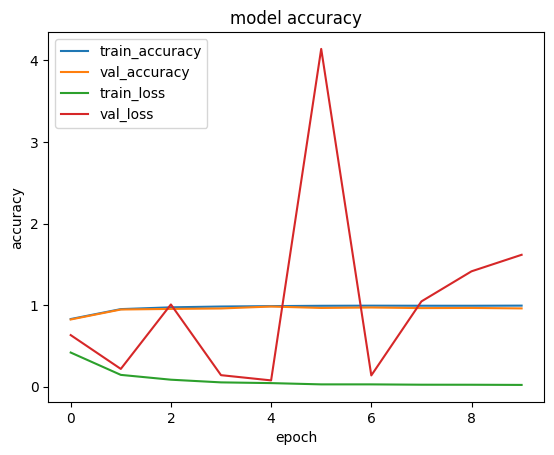

K-Fold Results:
Acuracy: 0.9405498504638672 	 +/- 0.020500163763900917
Precision: 0.8851517513394356 	 +/- 0.06000868404512675
Recall: 0.8891489654779434 	 +/- 0.08419989259591185
F1: 0.8823801259625019 	 +/- 0.03234596361880924


68/68 [==============================] - 1s 5ms/step - loss: 0.2228 - accuracy: 0.9504 - precision: 0.8547 - recall: 0.9579

Test Performance:
Test Accuracy: 0.950439989566803, Test Precision: 0.8547008633613586, Test Recall: 0.9578543901443481, Test F1 Score: 0.9033423644850719


In [22]:
k_fold_finetune_resnet(8, X_train, Y_train, freeze_layers=7, batch_size=32, epochs=10, weights_path='models/test_moco_model.h5', learning_rate=0.0005, num_classes=1)